# Training a neural network with McSnow output

This script applies a DNN to a regression problem 

Much of this follows the basic regression example from the Tensorflow tutorial

https://www.tensorflow.org/tutorials/keras/regression


In [1]:
version  = '06'

### Load Tensorflow and other useful modules

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

import pathlib

import pandas as pd
import seaborn as sns

import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt

print(tf.__version__)

2.1.0


In [3]:
tf.random.set_seed(1234)

### Load data from netcdf

In [4]:
import numpy as np
import xarray as xr

In [5]:
mdir='/Users/axel/DWD/GITLAB/mcsnow/'
edir='experiments/'

data="rimedsnow"

fname1=mdir+edir+'icebox_train_rc_'+data+'.nc'

ds1 = xr.open_dataset(fname1)
print('ds1: ', ds1)

ds1:  <xarray.Dataset>
Dimensions:                        (cell: 2150090)
Dimensions without coordinates: cell
Data variables: (12/204)
    time                           (cell) float32 ...
    q_cloud                        (cell) float32 ...
    n_cloud                        (cell) float32 ...
    q_rain                         (cell) float32 ...
    n_rain                         (cell) float32 ...
    q_ice                          (cell) float32 ...
    ...                             ...
    frze_graupel_rain_mass         (cell) float32 ...
    frze_graupel_rain_rmass        (cell) float32 ...
    frze_graupel_rain_rvol         (cell) float32 ...
    frze_graupel_rain_liq          (cell) float32 ...
    rime_graupel_rain_num          (cell) float32 ...
    rime_graupel_rain_mass         (cell) float32 ...
Attributes:
    title:    McSnow ice microphysics box model output pre-processed by NCL
    date:     Mo 30 Mai 2022 17:34:22 CEST
    nfiles:   10013


# Prepare data for training

In [6]:
def read_and_prepare_data(fname):
    # Read some data, we just want simple nparrays. Hence the .values
    temp = xr.open_dataset(fname).temp.values
    rho  = xr.open_dataset(fname).rho.values
    q_s  = xr.open_dataset(fname).q_rimedsnow.values
    n_s  = xr.open_dataset(fname).n_rimedsnow.values
    r_s  = xr.open_dataset(fname).rime_rimedsnow.values
    v_s  = xr.open_dataset(fname).rvol_rimedsnow.values
    liq  = xr.open_dataset(fname).liq_rimedsnow.values
    # reflectivity
    z_s  = xr.open_dataset(fname).z_rimedsnow.values
    # some numerical lower bounds
    q_min = 1e-20
    n_min = 1e-20
    z_min = 1e-20
    p_min = 1e-20
    # use liquid water fraction (no log transform for this)
    liq = np.where(q_s>q_min,liq/q_s,np.nan)  
    liq = np.where(liq>0.0,liq,np.nan)  
    # transform everything in log space
    n_s = np.log(n_s, where=n_s>n_min, out=np.nan*n_s)
    r_s = np.log(r_s, where=r_s>q_min, out=np.nan*n_s)
    v_s = np.log(v_s, where=v_s>q_min, out=np.nan*n_s)
    q_s = np.log(q_s, where=q_s>q_min, out=np.nan*n_s)
    z_s = np.log(z_s, where=z_s>q_min, out=np.nan*n_s)
    # put everything in a pandas dataframe
    dataset = pd.DataFrame(np.array( [ z_s, q_s, n_s, r_s, v_s, liq, temp, rho ]))
    dataset = dataset.T
    dataset.columns = [ 'z_s', 'q_s', 'n_s', 'r_s', 'v_s', 'liq', 'temp', 'rho' ] 
    # remove missing values immediately
    dataset = dataset.dropna()
    return dataset

In [7]:
df = read_and_prepare_data(fname1)

In [8]:
df.describe()

z_s           q_s           n_s           r_s           v_s  \
count  1.538275e+06  1.538275e+06  1.538275e+06  1.538275e+06  1.538275e+06   
mean  -9.938914e+00 -5.525222e+00  1.672461e+00 -6.642825e+00 -1.278597e+01   
std    6.734740e+00  1.570429e+00  4.766271e+00  2.310125e+00  2.197713e+00   
min   -4.036344e+01 -2.300340e+01 -1.449861e+01 -3.550022e+01 -4.052992e+01   
25%   -1.514129e+01 -5.922685e+00 -7.861291e-01 -7.352902e+00 -1.331558e+01   
50%   -1.181587e+01 -5.239614e+00  3.167077e+00 -6.191771e+00 -1.231192e+01   
75%   -4.135292e+00 -4.701923e+00  4.746236e+00 -5.218259e+00 -1.155190e+01   
max    7.153599e+00 -2.958918e+00  1.417661e+01 -3.173640e+00 -8.316296e+00   

                liq          temp           rho  
count  1.538275e+06  1.538275e+06  1.538275e+06  
mean   2.536074e-01  2.739276e+02  1.148872e+00  
std    2.757950e-01  4.140707e+00  7.776696e-02  
min    2.795219e-18  2.461000e+02  7.180000e-01  
25%    2.360296e-02  2.731800e+02  1.109000e+00  
50%    1.413432e-01  2.743000e+02  1.160000e+00  
75%    4.009340e-01  2.760500e+02  1.206000e+00  
max    1.000000e+00  2.901200e+02  1.289000e+00

### Split in training, testing and validation with 70/15/15 rule

In [9]:
msk = np.random.rand(len(df)) < 0.7
dataset_train = df[msk]

df2 = df[~msk]
msk = np.random.rand(len(df2)) < 0.5

dataset_test = df2[msk]
dataset_val = df2[~msk]

### Inspect the data

In [10]:
dataset_train.head()

z_s       q_s       n_s        r_s        v_s       liq        temp  \
2  -22.260290 -8.104156  8.323147 -10.500016 -15.516023  0.000005  266.019989   
33 -21.434374 -7.740004  8.215196  -8.954614 -14.015194  0.000105  268.220001   
36 -21.026129 -7.551674  8.208055  -8.434784 -13.488800  0.000165  268.440002   
38 -20.842703 -7.463456  8.204808  -8.239182 -13.291078  0.000044  268.609985   
39 -20.771606 -7.428177  8.203523  -8.166959 -13.218049  0.000050  268.690002   

      rho  
2   1.040  
33  1.079  
36  1.083  
38  1.086  
39  1.088

In [11]:
dataset_train.describe()

z_s           q_s           n_s           r_s           v_s  \
count  1.077272e+06  1.077272e+06  1.077272e+06  1.077272e+06  1.077272e+06   
mean  -9.942446e+00 -5.525755e+00  1.674157e+00 -6.644105e+00 -1.278697e+01   
std    6.735107e+00  1.571250e+00  4.767351e+00  2.313215e+00  2.201383e+00   
min   -4.036344e+01 -2.300340e+01 -1.449861e+01 -3.373029e+01 -4.001929e+01   
25%   -1.514248e+01 -5.923245e+00 -7.806460e-01 -7.353094e+00 -1.331546e+01   
50%   -1.182016e+01 -5.239596e+00  3.169034e+00 -6.192162e+00 -1.231190e+01   
75%   -4.140870e+00 -4.702593e+00  4.746843e+00 -5.218656e+00 -1.155223e+01   
max    7.153599e+00 -3.006065e+00  1.417661e+01 -3.287717e+00 -8.738650e+00   

                liq          temp           rho  
count  1.077272e+06  1.077272e+06  1.077272e+06  
mean   2.536161e-01  2.739264e+02  1.148800e+00  
std    2.758780e-01  4.140250e+00  7.775144e-02  
min    9.153621e-16  2.462400e+02  7.180000e-01  
25%    2.350610e-02  2.731800e+02  1.109000e+00  
50%    1.412639e-01  2.743000e+02  1.160000e+00  
75%    4.009464e-01  2.760500e+02  1.206000e+00  
max    1.000000e+00  2.901200e+02  1.289000e+00

In [12]:
dataset_test.describe()

z_s            q_s            n_s            r_s  \
count  230794.000000  230794.000000  230794.000000  230794.000000   
mean       -9.919144      -5.521172       1.662746      -6.637014   
std         6.730128       1.559305       4.761682       2.295709   
min       -39.774139     -22.967394     -14.498609     -35.500221   
25%       -15.130713      -5.921155      -0.804844      -7.353652   
50%       -11.799242      -5.239350       3.162263      -6.190062   
75%        -4.101807      -4.701563       4.742821      -5.218268   
max         7.138232      -2.958918      14.065724      -3.173640   

                 v_s           liq           temp            rho  
count  230794.000000  2.307940e+05  230794.000000  230794.000000  
mean      -12.781257  2.537543e-01     273.931335       1.149015  
std         2.180382  2.758461e-01       4.149734       0.077849  
min       -40.529922  3.585601e-14     246.100006       0.720000  
25%       -13.315463  2.367386e-02     273.179993       1.109000  
50%       -12.311922  1.417317e-01     274.299988       1.160000  
75%       -11.553768  4.005903e-01     276.070007       1.206000  
max        -8.316296  1.000000e+00     289.209991       1.289000

In [13]:
dataset_val.describe()

z_s            q_s            n_s            r_s  \
count  230209.000000  230209.000000  230209.000000  230209.000000   
mean       -9.942243      -5.526790       1.674262      -6.642662   
std         6.737635       1.577682       4.765830       2.310064   
min       -40.338760     -22.966734     -14.498609     -31.968380   
25%       -15.146710      -5.921715      -0.790738      -7.351187   
50%       -11.809137      -5.240011       3.162432      -6.192358   
75%        -4.144775      -4.698997       4.746323      -5.216848   
max         7.077076      -3.045322      13.455832      -3.381866   

                 v_s           liq           temp            rho  
count  230209.000000  2.302090e+05  230209.000000  230209.000000  
mean      -12.786059  2.534193e-01     273.929688       1.149069  
std         2.197836  2.753564e-01       4.133795       0.077757  
min       -37.614853  2.795219e-18     246.559998       0.722000  
25%       -13.315887  2.395139e-02     273.190002       1.109000  
50%       -12.311967  1.413247e-01     274.309998       1.161000  
75%       -11.548024  4.012478e-01     276.049988       1.206000  
max        -8.502255  9.999809e-01     289.839996       1.288000

### Further reduce data to relevant parameter range

In [14]:
def reduce_data(dataset):
    idx = dataset[ dataset['q_s'] < -20 ].index
    dataset.drop(idx,inplace=True)   
#    idx = dataset[ dataset['v_s'] > -5 ].index
#    dataset.drop(idx,inplace=True)   
    return dataset

In [15]:
dataset_test  = reduce_data(dataset_test)
dataset_train = reduce_data(dataset_train)
dataset_val   = reduce_data(dataset_val)

/usr/local/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [16]:
dataset_train.describe()

z_s           q_s           n_s           r_s           v_s  \
count  1.076404e+06  1.076404e+06  1.076404e+06  1.076404e+06  1.076404e+06   
mean  -9.924865e+00 -5.512856e+00  1.684357e+00 -6.629964e+00 -1.277270e+01   
std    6.708571e+00  1.504539e+00  4.754741e+00  2.258213e+00  2.142790e+00   
min   -3.685355e+01 -1.999872e+01 -1.449861e+01 -3.373029e+01 -3.946851e+01   
25%   -1.513606e+01 -5.920894e+00 -7.681725e-01 -7.349195e+00 -1.331213e+01   
50%   -1.181223e+01 -5.238785e+00  3.173292e+00 -6.190550e+00 -1.231072e+01   
75%   -4.133855e+00 -4.702077e+00  4.747711e+00 -5.217789e+00 -1.155166e+01   
max    7.153599e+00 -3.006065e+00  1.417661e+01 -3.287717e+00 -8.738650e+00   

                liq          temp           rho  
count  1.076404e+06  1.076404e+06  1.076404e+06  
mean   2.533730e-01  2.739243e+02  1.148781e+00  
std    2.756090e-01  4.139140e+00  7.776027e-02  
min    9.153621e-16  2.462400e+02  7.180000e-01  
25%    2.348356e-02  2.731800e+02  1.109000e+00  
50%    1.411670e-01  2.743000e+02  1.160000e+00  
75%    4.004692e-01  2.760500e+02  1.206000e+00  
max    1.000000e+00  2.901200e+02  1.289000e+00

In [17]:
dataset_test.describe()

z_s            q_s            n_s            r_s  \
count  230621.000000  230621.000000  230621.000000  230621.000000   
mean       -9.903016      -5.509283       1.672232      -6.623872   
std         6.706204       1.498048       4.749938       2.244222   
min       -36.410423     -19.992052     -14.498609     -35.500221   
25%       -15.123474      -5.918995      -0.791598      -7.349941   
50%       -11.791952      -5.238616       3.165855      -6.188405   
75%        -4.094204      -4.701208       4.743627      -5.217549   
max         7.138232      -2.958918      14.065724      -3.173640   

                 v_s           liq           temp            rho  
count  230621.000000  2.306210e+05  230621.000000  230621.000000  
mean      -12.768021  2.534915e-01     273.928894       1.148995  
std         2.125616  2.755754e-01       4.148370       0.077859  
min       -40.529922  3.585601e-14     246.100006       0.720000  
25%       -13.311952  2.362476e-02     273.179993       1.109000  
50%       -12.310988  1.416040e-01     274.299988       1.160000  
75%       -11.553247  3.999923e-01     276.070007       1.206000  
max        -8.316296  1.000000e+00     289.209991       1.289000

### Pairplot

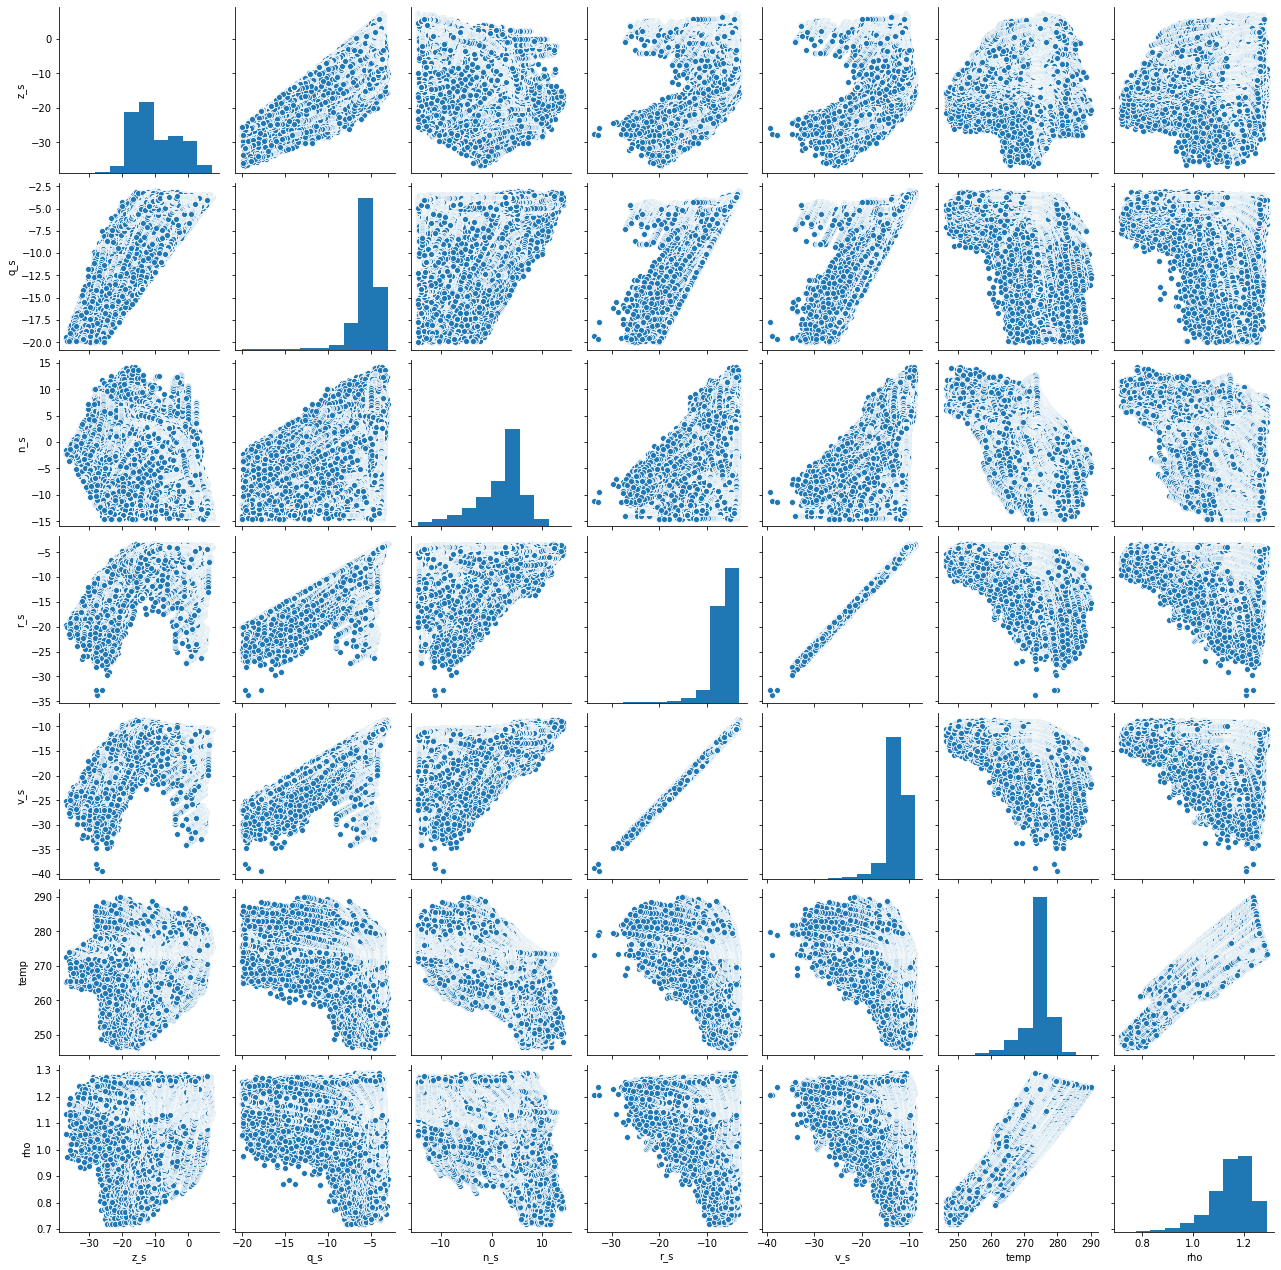

In [18]:
sns.pairplot(dataset_train[["z_s","q_s","n_s","r_s","v_s","temp","rho"]], diag_kind="hist")

## Separate in different dataset with selected sets of predictors

In [19]:
train_dataset1 = dataset_train.copy()
train_dataset2 = dataset_train.copy()
train_dataset3 = dataset_train.copy()
train_dataset4 = dataset_train.copy()
train_dataset5 = dataset_train.copy()

In [20]:
test_dataset1 = dataset_test.copy()
test_dataset2 = dataset_test.copy()
test_dataset3 = dataset_test.copy()
test_dataset4 = dataset_test.copy()
test_dataset5 = dataset_test.copy()

In [21]:
val_dataset1 = dataset_val.copy()
val_dataset2 = dataset_val.copy()
val_dataset3 = dataset_val.copy()
val_dataset4 = dataset_val.copy()
val_dataset5 = dataset_val.copy()

In [22]:
train_dataset1 = train_dataset1.drop(['liq','temp','rho'], axis=1)
train_dataset2 = train_dataset2.drop(['temp','rho'], axis=1)
#train_dataset3 = train_dataset3.drop(['ssi'], axis=1)
#train_dataset4 = train_dataset4.drop(['zi'], axis=1)
#train_dataset5 = train_dataset5.drop(['qs'], axis=1)

In [23]:
test_dataset1 = test_dataset1.drop(['liq','temp','rho'], axis=1)
test_dataset2 = test_dataset2.drop(['temp','rho'], axis=1)
#test_dataset3 = test_dataset3.drop(['ssi'], axis=1)
#test_dataset4 = test_dataset4.drop(['zi'], axis=1)
#test_dataset5 = test_dataset5.drop(['qs'], axis=1)

In [24]:
val_dataset1 = val_dataset1.drop(['liq','temp','rho'], axis=1)
val_dataset2 = val_dataset2.drop(['temp','rho'], axis=1)
#val_dataset3 = val_dataset3.drop(['ssi'], axis=1)
#val_dataset4 = val_dataset4.drop(['zi'], axis=1)
#val_dataset5 = val_dataset5.drop(['qs'], axis=1)

In [25]:
train_stats1 = train_dataset1.describe()
train_stats1.pop("z_s")
train_stats1 = train_stats1.transpose()
train_stats1

count       mean       std        min        25%        50%  \
q_s  1076404.0  -5.512856  1.504539 -19.998716  -5.920894  -5.238785   
n_s  1076404.0   1.684357  4.754741 -14.498609  -0.768173   3.173292   
r_s  1076404.0  -6.629964  2.258213 -33.730293  -7.349195  -6.190550   
v_s  1076404.0 -12.772704  2.142790 -39.468513 -13.312133 -12.310722   

           75%        max  
q_s  -4.702077  -3.006065  
n_s   4.747711  14.176606  
r_s  -5.217789  -3.287717  
v_s -11.551656  -8.738650

In [26]:
train_stats2 = train_dataset2.describe()
train_stats2.pop("z_s")
train_stats2 = train_stats2.transpose()
train_stats2

count       mean       std           min        25%        50%  \
q_s  1076404.0  -5.512856  1.504539 -1.999872e+01  -5.920894  -5.238785   
n_s  1076404.0   1.684357  4.754741 -1.449861e+01  -0.768173   3.173292   
r_s  1076404.0  -6.629964  2.258213 -3.373029e+01  -7.349195  -6.190550   
v_s  1076404.0 -12.772704  2.142790 -3.946851e+01 -13.312133 -12.310722   
liq  1076404.0   0.253373  0.275609  9.153621e-16   0.023484   0.141167   

           75%        max  
q_s  -4.702077  -3.006065  
n_s   4.747711  14.176606  
r_s  -5.217789  -3.287717  
v_s -11.551656  -8.738650  
liq   0.400469   1.000000

In [27]:
train_stats3 = train_dataset3.describe()
train_stats3.pop("z_s")
train_stats3 = train_stats3.transpose()
train_stats3

count        mean       std           min         25%         50%  \
q_s   1076404.0   -5.512856  1.504539 -1.999872e+01   -5.920894   -5.238785   
n_s   1076404.0    1.684357  4.754741 -1.449861e+01   -0.768173    3.173292   
r_s   1076404.0   -6.629964  2.258213 -3.373029e+01   -7.349195   -6.190550   
v_s   1076404.0  -12.772704  2.142790 -3.946851e+01  -13.312133  -12.310722   
liq   1076404.0    0.253373  0.275609  9.153621e-16    0.023484    0.141167   
temp  1076404.0  273.924316  4.139140  2.462400e+02  273.179993  274.299988   
rho   1076404.0    1.148781  0.077760  7.180000e-01    1.109000    1.160000   

             75%         max  
q_s    -4.702077   -3.006065  
n_s     4.747711   14.176606  
r_s    -5.217789   -3.287717  
v_s   -11.551656   -8.738650  
liq     0.400469    1.000000  
temp  276.049988  290.119995  
rho     1.206000    1.289000

### Split features from labels (here we need only one set of labels)

Separate the target value, or "label", from the features. This label is the value that you will train the model to predict.

In [28]:
# pop does not work for multiple columns, use copy instead

labels = [ 'z_s' ]

train_labels = train_dataset1[labels].copy()
train_dataset1.drop(labels, axis=1, inplace=True)

test_labels = test_dataset1[labels].copy()
test_dataset1.drop(labels, axis=1, inplace=True)

val_labels = val_dataset1[labels].copy()
val_dataset1.drop(labels, axis=1, inplace=True)

In [29]:
train_dataset2.drop(labels, axis=1, inplace=True)
test_dataset2.drop(labels, axis=1, inplace=True)
val_dataset2.drop(labels, axis=1, inplace=True)

In [30]:
train_dataset3.drop(labels, axis=1, inplace=True)
test_dataset3.drop(labels, axis=1, inplace=True)
val_dataset3.drop(labels, axis=1, inplace=True)

In [31]:
train_labels.describe()

z_s
count  1.076404e+06
mean  -9.924865e+00
std    6.708571e+00
min   -3.685355e+01
25%   -1.513606e+01
50%   -1.181223e+01
75%   -4.133855e+00
max    7.153599e+00

In [32]:
train_dataset1.describe()

q_s           n_s           r_s           v_s
count  1.076404e+06  1.076404e+06  1.076404e+06  1.076404e+06
mean  -5.512856e+00  1.684357e+00 -6.629964e+00 -1.277270e+01
std    1.504539e+00  4.754741e+00  2.258213e+00  2.142790e+00
min   -1.999872e+01 -1.449861e+01 -3.373029e+01 -3.946851e+01
25%   -5.920894e+00 -7.681725e-01 -7.349195e+00 -1.331213e+01
50%   -5.238785e+00  3.173292e+00 -6.190550e+00 -1.231072e+01
75%   -4.702077e+00  4.747711e+00 -5.217789e+00 -1.155166e+01
max   -3.006065e+00  1.417661e+01 -3.287717e+00 -8.738650e+00

In [33]:
train_dataset2.describe()

q_s           n_s           r_s           v_s           liq
count  1.076404e+06  1.076404e+06  1.076404e+06  1.076404e+06  1.076404e+06
mean  -5.512856e+00  1.684357e+00 -6.629964e+00 -1.277270e+01  2.533730e-01
std    1.504539e+00  4.754741e+00  2.258213e+00  2.142790e+00  2.756090e-01
min   -1.999872e+01 -1.449861e+01 -3.373029e+01 -3.946851e+01  9.153621e-16
25%   -5.920894e+00 -7.681725e-01 -7.349195e+00 -1.331213e+01  2.348356e-02
50%   -5.238785e+00  3.173292e+00 -6.190550e+00 -1.231072e+01  1.411670e-01
75%   -4.702077e+00  4.747711e+00 -5.217789e+00 -1.155166e+01  4.004692e-01
max   -3.006065e+00  1.417661e+01 -3.287717e+00 -8.738650e+00  1.000000e+00

In [34]:
train_dataset3.describe()

q_s           n_s           r_s           v_s           liq  \
count  1.076404e+06  1.076404e+06  1.076404e+06  1.076404e+06  1.076404e+06   
mean  -5.512856e+00  1.684357e+00 -6.629964e+00 -1.277270e+01  2.533730e-01   
std    1.504539e+00  4.754741e+00  2.258213e+00  2.142790e+00  2.756090e-01   
min   -1.999872e+01 -1.449861e+01 -3.373029e+01 -3.946851e+01  9.153621e-16   
25%   -5.920894e+00 -7.681725e-01 -7.349195e+00 -1.331213e+01  2.348356e-02   
50%   -5.238785e+00  3.173292e+00 -6.190550e+00 -1.231072e+01  1.411670e-01   
75%   -4.702077e+00  4.747711e+00 -5.217789e+00 -1.155166e+01  4.004692e-01   
max   -3.006065e+00  1.417661e+01 -3.287717e+00 -8.738650e+00  1.000000e+00   

               temp           rho  
count  1.076404e+06  1.076404e+06  
mean   2.739243e+02  1.148781e+00  
std    4.139140e+00  7.776027e-02  
min    2.462400e+02  7.180000e-01  
25%    2.731800e+02  1.109000e+00  
50%    2.743000e+02  1.160000e+00  
75%    2.760500e+02  1.206000e+00  
max    2.901200e+02  1.289000e+00

### Normalize the features

In [35]:
def norm(x,stats):
  return (x - stats['mean']) / stats['std']

normed_train_data1 = norm(train_dataset1,train_stats1)
normed_train_data2 = norm(train_dataset2,train_stats2)
normed_train_data3 = norm(train_dataset3,train_stats3)

normed_test_data1 = norm(test_dataset1,train_stats1)
normed_test_data2 = norm(test_dataset2,train_stats2)
normed_test_data3 = norm(test_dataset3,train_stats3)

normed_val_data1 = norm(val_dataset1,train_stats1)
normed_val_data2 = norm(val_dataset2,train_stats2)
normed_val_data3 = norm(val_dataset3,train_stats3)

In [36]:
normed_train_stats1 = normed_train_data1.describe()
normed_train_stats1 = normed_train_stats1.transpose()
normed_train_stats1

count          mean  std        min       25%       50%       75%  \
q_s  1076404.0 -6.196899e-07  1.0  -9.628104 -0.271205  0.182162  0.538888   
n_s  1076404.0 -2.817223e-08  1.0  -3.403543 -0.515807  0.313147  0.644273   
r_s  1076404.0  5.369455e-07  1.0 -12.000788 -0.318496  0.194585  0.625351   
v_s  1076404.0 -8.870239e-08  1.0 -12.458437 -0.251741  0.215598  0.569841   

          max  
q_s  1.666151  
n_s  2.627325  
r_s  1.480041  
v_s  1.882618

In [37]:
normed_train_stats2 = normed_train_data2.describe()
normed_train_stats2 = normed_train_stats2.transpose()
normed_train_stats2

count          mean  std        min       25%       50%       75%  \
q_s  1076404.0 -6.196899e-07  1.0  -9.628104 -0.271205  0.182162  0.538888   
n_s  1076404.0 -2.817223e-08  1.0  -3.403543 -0.515807  0.313147  0.644273   
r_s  1076404.0  5.369455e-07  1.0 -12.000788 -0.318496  0.194585  0.625351   
v_s  1076404.0 -8.870239e-08  1.0 -12.458437 -0.251741  0.215598  0.569841   
liq  1076404.0 -1.259727e-07  1.0  -0.919321 -0.834114 -0.407120  0.533714   

          max  
q_s  1.666151  
n_s  2.627325  
r_s  1.480041  
v_s  1.882618  
liq  2.709009

In [38]:
normed_train_stats3 = normed_train_data3.describe()
normed_train_stats3 = normed_train_stats3.transpose()
normed_train_stats3

count          mean  std        min       25%       50%       75%  \
q_s   1076404.0 -6.196899e-07  1.0  -9.628104 -0.271205  0.182162  0.538888   
n_s   1076404.0 -2.817223e-08  1.0  -3.403543 -0.515807  0.313147  0.644273   
r_s   1076404.0  5.369455e-07  1.0 -12.000788 -0.318496  0.194585  0.625351   
v_s   1076404.0 -8.870239e-08  1.0 -12.458437 -0.251741  0.215598  0.569841   
liq   1076404.0 -1.259727e-07  1.0  -0.919321 -0.834114 -0.407120  0.533714   
temp  1076404.0 -7.265697e-06  1.0  -6.688421 -0.179826  0.090761  0.513554   
rho   1076404.0  4.823843e-06  1.0  -5.539865 -0.511591  0.144271  0.735833   

           max  
q_s   1.666151  
n_s   2.627325  
r_s   1.480041  
v_s   1.882618  
liq   2.709009  
temp  3.912812  
rho   1.803217

### Normalize the labels

In [39]:
train_labels_stats = train_labels.describe()
train_labels_stats = train_labels_stats.transpose()
train_labels_stats

count      mean       std        min        25%        50%       75%  \
z_s  1076404.0 -9.924865  6.708571 -36.853554 -15.136064 -11.812235 -4.133855   

          max  
z_s  7.153599

In [40]:
normed_train_labels = norm(train_labels,train_labels_stats)
normed_test_labels = norm(test_labels,train_labels_stats)
normed_val_labels = norm(val_labels,train_labels_stats)

# The model

## Build the model

In [41]:
def build_model_sigm(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='sigmoid', input_shape=[ncol]),
    layers.Dense(nsize, activation='sigmoid'),
    layers.Dense(nsize, activation='sigmoid'),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model


def build_model_tanh(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='tanh', input_shape=[ncol]),
    layers.Dense(nsize, activation='tanh'),
    layers.Dense(nsize, activation='tanh'),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# scaled exponential linear unit (Klambauer et al. 2015) with LeCun initialization
def build_model_selu(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='tanh', input_shape=[ncol]),
    layers.Dense(nsize, activation='selu', kernel_initializer="lecun_normal"),
    layers.Dense(nsize, activation='selu', kernel_initializer="lecun_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Most common activation piecewise linear function, which should be use with He-initialization
def build_model_relu(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='relu', input_shape=[ncol]),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Leaky ReLU with max(alpha*z,z), which helps to avoid dying neurons
def build_model_leaky_relu(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, input_shape=[ncol]),
    layers.Dense(nsize, kernel_initializer="he_normal"),
    layers.LeakyReLU(alpha=0.2),
    layers.Dense(nsize, kernel_initializer="he_normal"),
    layers.LeakyReLU(alpha=0.2),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Parametric leaky ReLU with max(alpha*z,z), but alpha is now a trainable parameter
# This has a strongly increased risk of overfitting!
def build_model_param_relu(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, input_shape=[ncol]),
    layers.Dense(nsize, kernel_initializer="he_normal"),
    layers.PReLU(),
    layers.Dense(nsize, kernel_initializer="he_normal"),
    layers.PReLU(),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Here we use the Nesterov Accelerated Gradient (NAG) optimizer (see Chapter 12 of Hands-On ML)
def build_model_relu_SGD(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='relu', input_shape=[ncol]),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.SGD(lr=learn, momentum=0.9, nesterov=True)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# and the Adam optimizer (see Chapter 12 of Hands-On ML)
def build_model_relu_Adam(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='relu', input_shape=[ncol]),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.Adam(lr=learn, beta_1=0.9, beta_2=0.999)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Here we use the Nesterov Accelerated Gradient (NAG) optimizer (see Chapter 12 of Hands-On ML)
def build_model_relu_SGD_H6(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='relu', input_shape=[ncol]),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.SGD(lr=learn, momentum=0.9, nesterov=True)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# and the Adam optimizer (see Chapter 12 of Hands-On ML)
def build_model_relu_Adam_H6(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='relu', input_shape=[ncol]),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.Adam(lr=learn, beta_1=0.9, beta_2=0.999)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

def build_model(ncol,nsize,activation,learning_rate):
    if activation == "sigm":
        model = build_model_sigm(ncol,nsize,learning_rate)
    elif activation == "tanh":
        model = build_model_tanh(ncol,nsize,learning_rate)
    elif activation == "SELU":
        model = build_model_selu(ncol,nsize,learning_rate)
    elif activation == "ReLU":
        model = build_model_relu(ncol,nsize,learning_rate)
    elif activation == "ReLU_SGD":
        model = build_model_relu_SGD(ncol,nsize,learning_rate)
    elif activation == "ReLU_Adam":
        model = build_model_relu_Adam(ncol,nsize,learning_rate)
    elif activation == "ReLU_SGD_H6":
        model = build_model_relu_SGD_H6(ncol,nsize,learning_rate)
    elif activation == "ReLU_Adam_H6":
        model = build_model_relu_Adam_H6(ncol,nsize,learning_rate)
    elif activation == "LReLU":
        model = build_model_leaky_relu(ncol,nsize,learning_rate)
    elif activation == "PReLU":
        model = build_model_param_relu(ncol,nsize,learning_rate)
    else:
        print("Error: Wrong choice for activation")
    return model        

In [42]:

activ = "sigm"
    
#activ = "PReLU"
#activ = "LReLU"
#activ = "tanh"
#activ = "ReLU_SGD"
#activ = "ReLU_Adam"
#activ = "ReLU"

model = build_model(4,16,activ,1e-3)

### Inspect the model

Use the `.summary` method to print a simple description of the model

In [43]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                80        
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 641
Trainable params: 641
Non-trainable params: 0
_________________________________________________________________


Now try out the model. Take a batch of `10` examples from the training data and call `model.predict` on it.

In [44]:
example_batch  = normed_train_data1[:10]
example_result = model.predict(example_batch)
example_result

array([[-0.82342595],
       [-0.83381706],
       [-0.83798677],
       [-0.83964646],
       [-0.84027255],
       [-0.8408019 ],
       [-0.8412509 ],
       [-0.8419445 ],
       [-0.842209  ],
       [-0.8436641 ]], dtype=float32)

It seems to be working, if it produces a result of the expected shape and type and no NaN.

# Train the model

Use early stopping

In [45]:
# maximum number, but we use early stopping
EPOCHS = 300

# learning rate
learn = 1e-3       # original value is 1e-3, but smaller might be better?

# width of neural net
nsize = 16

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', restore_best_weights=True, patience=10)

# for collecting the histories
histories = {}

# make plots bigger than standard layout
SMALL_SIZE = 15
MEDIUM_SIZE = 25
BIGGER_SIZE = 25
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rcParams["figure.figsize"] = (18,8)  # increase plot size

In [46]:
activ = "sigm"
model1 = build_model(len(normed_train_data1.keys()),nsize,activ,learn)

early_history1 = model1.fit(normed_train_data1, normed_train_labels, 
                    epochs=EPOCHS, validation_data=[normed_val_data1,normed_val_labels], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.0441,  mae:0.1435,  mse:0.0441,  val_loss:0.0324,  val_mae:0.1264,  val_mse:0.0324,  
..........................................................

Text(0, 0.5, 'MAE')

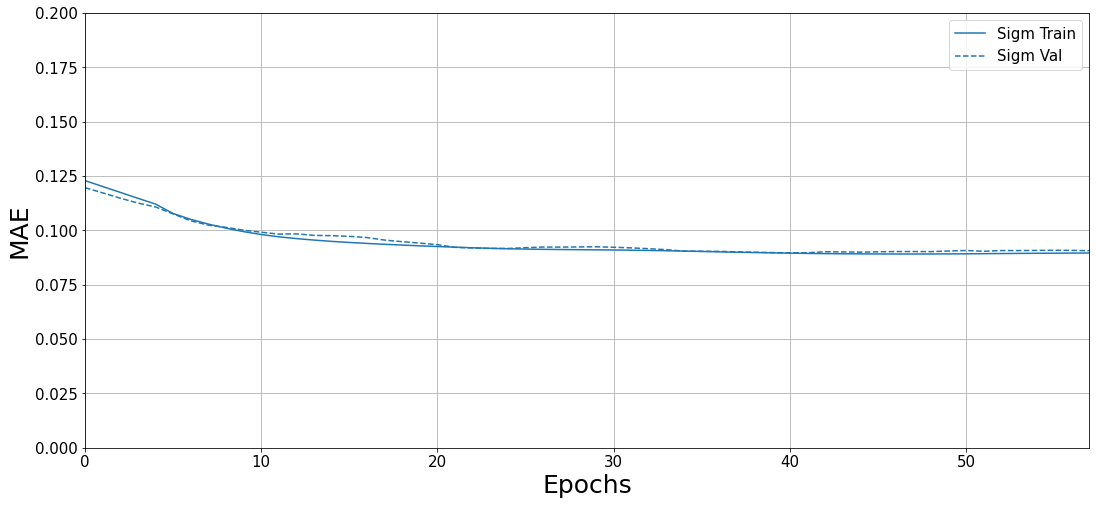

In [47]:
histories['sigm'] = early_history1

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0.0,0.2])
plt.ylabel('MAE')

In [48]:
activ = "ReLU"
model2 = build_model(len(normed_train_data1.keys()),nsize,activ,learn)

early_history2 = model2.fit(normed_train_data1, normed_train_labels, 
                    epochs=EPOCHS, validation_data=[normed_val_data1,normed_val_labels], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.0244,  mae:0.1018,  mse:0.0244,  val_loss:0.0209,  val_mae:0.0935,  val_mse:0.0209,  
.....................

Text(0, 0.5, 'MAE')

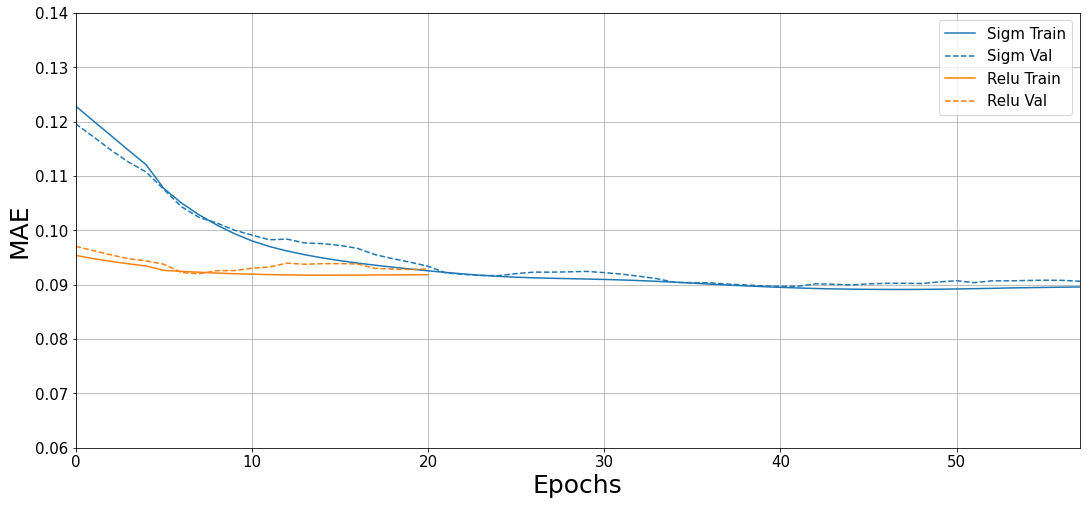

In [49]:
histories['ReLU'] = early_history2

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0.06, 0.14])
plt.ylabel('MAE')

In [50]:
activ = "ReLU_Adam"
model3 = build_model(len(normed_train_data1.keys()),nsize,activ,learn)

early_history3 = model3.fit(normed_train_data1, normed_train_labels, 
                    epochs=EPOCHS, validation_data=[normed_val_data1,normed_val_labels], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.0238,  mae:0.1010,  mse:0.0238,  val_loss:0.0200,  val_mae:0.0917,  val_mse:0.0200,  
....................................

Text(0, 0.5, 'MAE')

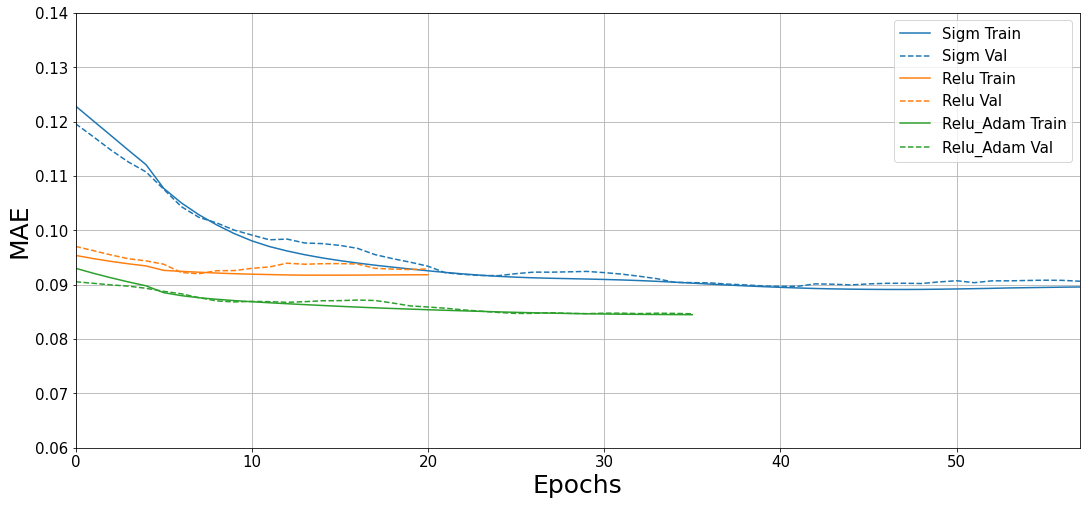

In [51]:
histories['ReLU_Adam'] = early_history3

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0.06, 0.14])
plt.ylabel('MAE')

In [52]:
activ = "ReLU_Adam"
model4 = build_model(len(normed_train_data2.keys()),nsize,activ,learn)

early_history4 = model4.fit(normed_train_data2, normed_train_labels, 
                    epochs=EPOCHS, validation_data=[normed_val_data2,normed_val_labels], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.0171,  mae:0.0825,  mse:0.0171,  val_loss:0.0115,  val_mae:0.0711,  val_mse:0.0115,  
..........................................

Text(0, 0.5, 'MAE')

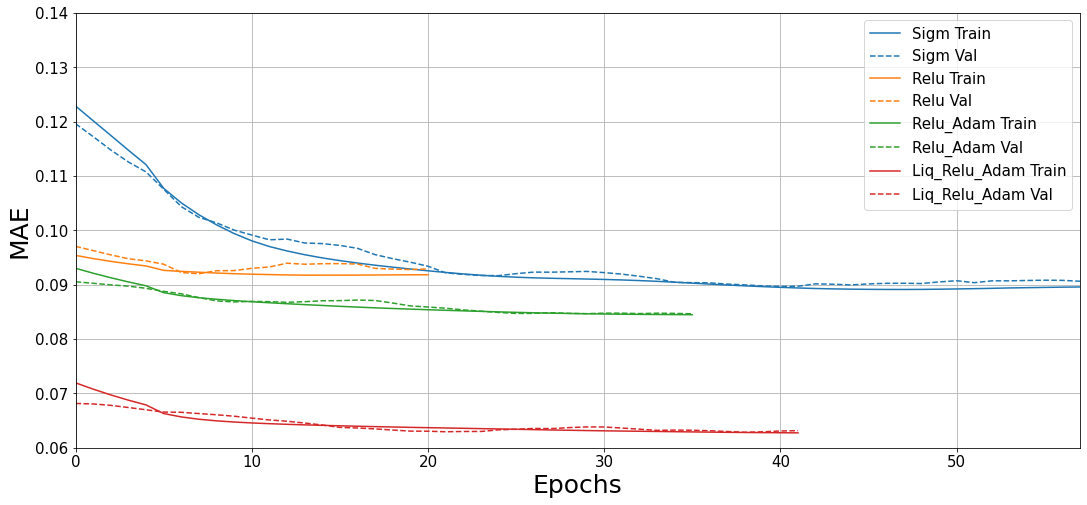

In [53]:
histories['liq_ReLU_Adam'] = early_history4

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0.06, 0.14])
plt.ylabel('MAE')

In [54]:
activ = "ReLU_Adam"
model5 = build_model(len(normed_train_data3.keys()),nsize,activ,learn)

early_history5 = model5.fit(normed_train_data3, normed_train_labels, 
                    epochs=EPOCHS, validation_data=[normed_val_data3,normed_val_labels], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.0175,  mae:0.0847,  mse:0.0175,  val_loss:0.0111,  val_mae:0.0702,  val_mse:0.0111,  
..........................................

Text(0, 0.5, 'MAE')

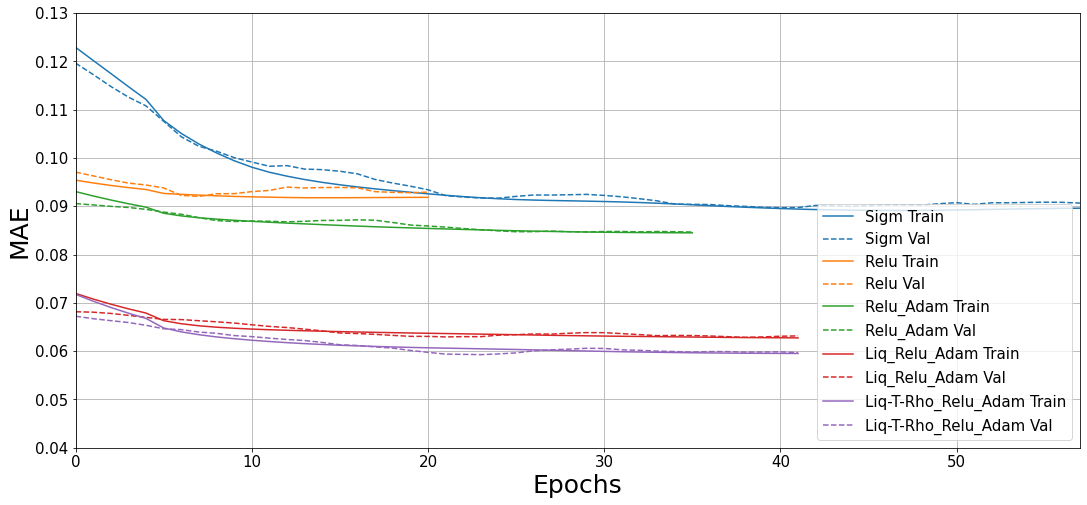

In [55]:
histories['liq-T-rho_ReLU_Adam'] = early_history5

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0.04, 0.13])
plt.ylabel('MAE')

In [56]:
nsize = 32
activ = "ReLU_Adam"
model6 = build_model(len(normed_train_data3.keys()),nsize,activ,learn)

early_history6 = model6.fit(normed_train_data3, normed_train_labels, 
                    epochs=EPOCHS, validation_data=[normed_val_data3,normed_val_labels], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.0126,  mae:0.0760,  mse:0.0126,  val_loss:0.0091,  val_mae:0.0631,  val_mse:0.0091,  
..............................................................

In [57]:
histories['liq-T-rho_ReLU_Adam_32'] = early_history6

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0.04, 0.13])
plt.ylabel('MAE')

Text(0, 0.5, 'MAE')

In [58]:
plotter.plot(histories, metric = "mse")
plt.ylim([0.0, 0.04])
plt.ylabel('MSE')

Text(0, 0.5, 'MSE')

In [59]:
loss1, mae1, mse1 = model1.evaluate(normed_test_data1, normed_test_labels, verbose=2)

print("Testing set for model 1, Mean Abs Error: {:10.5f}".format(mae1))

230621/230621 - 6s - loss: 0.0183 - mae: 0.0876 - mse: 0.0183
Testing set for model 1, Mean Abs Error:    0.08759


In [60]:
loss2, mae2, mse2 = model2.evaluate(normed_test_data1, normed_test_labels, verbose=2)

print("Testing set for model 2, Mean Abs Error: {:10.5f}".format(mae1))

230621/230621 - 5s - loss: 0.0198 - mae: 0.0889 - mse: 0.0198
Testing set for model 2, Mean Abs Error:    0.08759


In [61]:
loss3, mae3, mse3 = model3.evaluate(normed_test_data1, normed_test_labels, verbose=2)

print("Testing set for model 3, Mean Abs Error: {:10.5f}".format(mae1))

230621/230621 - 5s - loss: 0.0168 - mae: 0.0839 - mse: 0.0168
Testing set for model 3, Mean Abs Error:    0.08759


In [62]:
loss4, mae4, mse4 = model4.evaluate(normed_test_data2, normed_test_labels, verbose=2)

print("Testing set for model 4, Mean Abs Error: {:20.5f}".format(mae4))

230621/230621 - 6s - loss: 0.0087 - mae: 0.0623 - mse: 0.0087
Testing set for model 4, Mean Abs Error:              0.06230


In [63]:
loss5, mae5, mse5 = model5.evaluate(normed_test_data3, normed_test_labels, verbose=2)

print("Testing set for model 5, Mean Abs Error: {:20.5f}".format(mae4))

230621/230621 - 5s - loss: 0.0076 - mae: 0.0583 - mse: 0.0076
Testing set for model 5, Mean Abs Error:              0.06230


In [64]:
loss6, mae6, mse6 = model6.evaluate(normed_test_data3, normed_test_labels, verbose=2)

print("Testing set for model 6, Mean Abs Error: {:20.5f}".format(mae6))

230621/230621 - 5s - loss: 0.0060 - mae: 0.0515 - mse: 0.0060
Testing set for model 6, Mean Abs Error:              0.05147


In [65]:
mae = [ mae1, mae2, mae3, mae4, mae5, mae6 ]
mae

[0.08759397, 0.08893546, 0.08391111, 0.06229913, 0.05827561, 0.05147235]

In [66]:
mse = [ mse1, mse2, mse3, mse4, mse5, mse6 ]
mse

[0.018286007, 0.019838838, 0.016848529, 0.008749354, 0.007570272, 0.006009761]

In [67]:
SMALL_SIZE = 15
MEDIUM_SIZE = 25
BIGGER_SIZE = 25

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize

plt.rcParams["figure.figsize"] = (18,8)  # increase plot size

labels = ['model 1:\n base \n sigm',
 'model 2:\n base \n ReLU',
 'model 3:\n base \n ReLU_Adam',
 'model 4:\n +liq \n ReLU_Adam',
 'model 5:\n +liq+rho+T \n ReLU_Adam',
 'model 6:\n +liq+rho+T \n ReLU_Adam_32']

x = np.arange(len(labels))  # the label locations
width = 0.3  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, mse, width, label='MSE')
rects2 = ax.bar(x + width/2, mae, width, label='MAE')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('machine learning result for normalized reflectivity')
ax.set_xticks(x)
ax.set_xticklabels(labels)
#ax.set_ylim(0,3e-8)
ax.legend()

#fig.tight_layout()

plt.show()

# Make predictions

Finally, predict the values using data in the testing set:

In [68]:
test_true_z  = np.exp(test_labels.pop('z_s'))

In [69]:
def backtransform(x,stats):
  return x*stats['std']+stats['mean']

In [70]:
p1 = pd.DataFrame(data=model1.predict(normed_test_data1), columns=["z_s"])

In [71]:
p1.describe()

z_s
count  230621.000000
mean        0.001091
std         0.994717
min        -3.390485
25%        -0.774331
50%        -0.265872
75%         0.861265
max         2.425347

In [72]:
train_labels_stats

count      mean       std        min        25%        50%       75%  \
z_s  1076404.0 -9.924865  6.708571 -36.853554 -15.136064 -11.812235 -4.133855   

          max  
z_s  7.153599

In [73]:
test_predict1 = np.exp(backtransform(p1,train_labels_stats))

In [74]:
test_predict1.describe()

z_s
count  2.306210e+05
mean   3.345008e+00
std    2.540956e+01
min    6.479222e-15
25%    2.714417e-07
50%    8.223709e-06
75%    1.581166e-02
max    5.700635e+02

In [75]:
test_predict1_z  = test_predict1['z_s']

In [76]:

p2 = pd.DataFrame(data=model4.predict(normed_test_data2), columns=["z_s"])

test_predict2 = np.exp(backtransform(p2,train_labels_stats))

test_predict2_z = test_predict2['z_s']

In [77]:

p3 = pd.DataFrame(data=model6.predict(normed_test_data3), columns=["z_s"])

test_predict3 = np.exp(backtransform(p3,train_labels_stats))

test_predict3_z = test_predict3['z_s']

### Maybe the ordering of the arrays is different? 

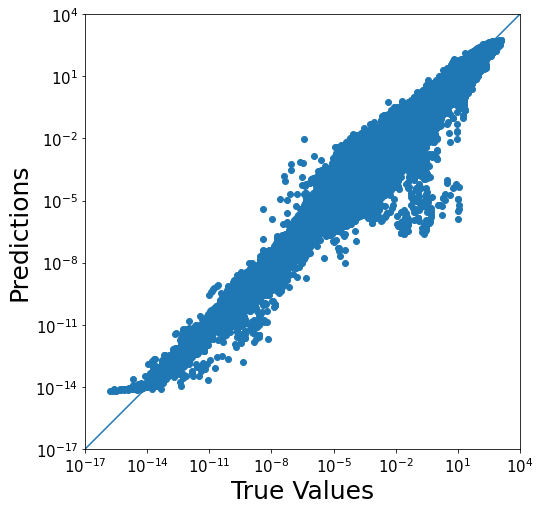

In [78]:
plt.rcParams["figure.figsize"] = (18,8)  # increase plot size

amin, amax = 1e-17, 1e4

a = plt.axes(aspect='equal')
plt.scatter(test_true_z, test_predict1_z)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

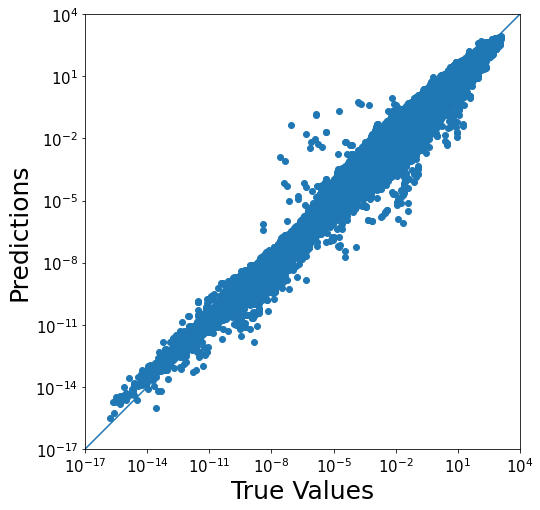

In [79]:
a = plt.axes(aspect='equal')
plt.scatter(test_true_z, test_predict2_z)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

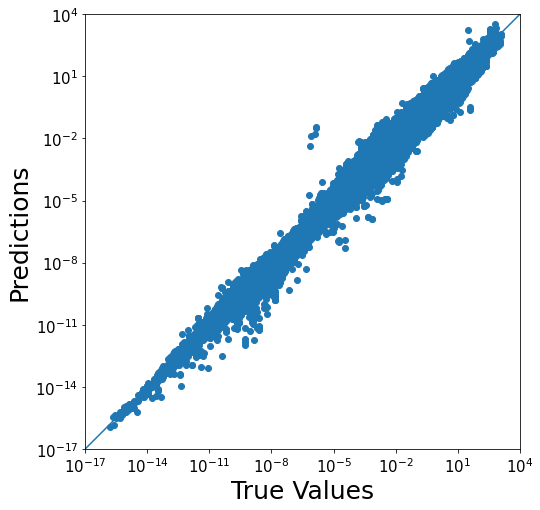

In [80]:
a = plt.axes(aspect='equal')
plt.scatter(test_true_z, test_predict3_z)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

# Save models to file

In [81]:
# Save the entire model as a SavedModel.
!mkdir -p saved_model_v2
   

In [82]:
def save2netcdf(model, features_str, labels_str, features_norm, labels_norm, features_ltf, outpath, verbose=True):
    # borrowed from Fabian Jakub, LMU Munich
    # https://github.com/tenstream/tenstream/blob/master/misc/LUT_to_Keras.py

    if model is None:
        D = xr.Dataset()
        D.to_netcdf(outpath)
        return

    layers = [ l for l in model.layers if 'Dropout' not in str(type(l)) ]
    if verbose:
        print("Saving model to "+outpath)
        print("  Features:   "+features_str)
        print("  Labels:     "+labels_str)
        for i,l in enumerate(layers):
            print("  Layer {}: {}, {}, Activation: {}".format(i, str(type(l)), l.weights[0].shape,l.activation.__name__))

    D = xr.Dataset()
    D.attrs['Nlayer'] = np.int32(len(layers))
    D.attrs['features']  = features_str
    D.attrs['labels'] = labels_str
    D.attrs['keras_name'] = model.name

    for i, l in enumerate(layers):
        D["w{}".format(i)] = xr.DataArray(l.weights[0].numpy(), dims=("Ninp_{}".format(i), "Nout_{}".format(i)))
        D["b{}".format(i)] = xr.DataArray(l.weights[1].numpy(), dims=("Nout_{}".format(i)))
        D["w{}".format(i)].attrs['activation'] = l.activation.__name__

        
    # write arrays for logtransform and normalization of input and output data to netcdf
    nout = len(layers)-1
    D["inp_logtransform"] = xr.DataArray(features_ltf, dims=("Ninp_0"))
    D["inp_norm_mean"] = xr.DataArray(features_norm['mean'].values, dims=("Ninp_0"))
    D["inp_norm_std"]  = xr.DataArray(features_norm['std'].values, dims=("Ninp_0"))
    D["out_norm_mean"] = xr.DataArray(labels_norm['mean'].values, dims=("Nout_{}".format(nout)))
    D["out_norm_std"]  = xr.DataArray(labels_norm['std'].values, dims=("Nout_{}".format(nout)))
    
    D.to_netcdf(outpath)

In [83]:

features = 'q_rimedsnow, n_rimedsnow, rmass_rimedsnow, rvol_rimedsnow'
labels   = 'z_rimedsnow'
logtransform = np.array([True, True, True, True], dtype=bool)

save2netcdf(model1,features,labels,train_stats1,train_labels_stats,logtransform,'saved_model_v2/refl_rimedsnow_model1_'+version+'.nc')
save2netcdf(model2,features,labels,train_stats1,train_labels_stats,logtransform,'saved_model_v2/refl_rimedsnow_model2_'+version+'.nc')
save2netcdf(model3,features,labels,train_stats1,train_labels_stats,logtransform,'saved_model_v2/refl_rimedsnow_model3_'+version+'.nc')

features = 'q_rimedsnow, n_rimedsnow, rmass_rimedsnow, rvol_rimedsnow, liqfrac'
labels   = 'z_rimedsnow'
logtransform = np.array([True, True, True, True, False], dtype=bool)

save2netcdf(model4,features,labels,train_stats2,train_labels_stats,logtransform,'saved_model_v2/refl_rimedsnow_model4_'+version+'.nc')

features = 'q_rimedsnow, n_rimedsnow, rmass_rimedsnow, rvol_rimedsnow, liqfrac, T, rho'
labels   = 'z_rimedsnow'
logtransform = np.array([True, True, True, True, False, False, False], dtype=bool)
save2netcdf(model5,features,labels,train_stats3,train_labels_stats,logtransform,'saved_model_v2/refl_rimedsnow_model5_'+version+'.nc')
save2netcdf(model6,features,labels,train_stats3,train_labels_stats,logtransform,'saved_model_v2/refl_rimedsnow_model6_'+version+'.nc')






Saving model to saved_model_v2/refl_rimedsnow_model1_06.nc
  Features:   q_rimedsnow, n_rimedsnow, rmass_rimedsnow, rvol_rimedsnow
  Labels:     z_rimedsnow
  Layer 0: <class 'tensorflow.python.keras.layers.core.Dense'>, (4, 16), Activation: sigmoid
  Layer 1: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 16), Activation: sigmoid
  Layer 2: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 16), Activation: sigmoid
  Layer 3: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 1), Activation: linear
Saving model to saved_model_v2/refl_rimedsnow_model2_06.nc
  Features:   q_rimedsnow, n_rimedsnow, rmass_rimedsnow, rvol_rimedsnow
  Labels:     z_rimedsnow
  Layer 0: <class 'tensorflow.python.keras.layers.core.Dense'>, (4, 16), Activation: relu
  Layer 1: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 16), Activation: relu
  Layer 2: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 16), Activation: relu
  Layer 3: <class 'tensorflow.python.kera